In [ ]:
#对比学习

In [1]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.4 MB/s eta 0:00:00


In [3]:
"""
#VGG
import torch
import torch.nn as nn

import torch
import torch.nn as nn
#from torchvision.models.utils import load_state_dict_from_url
from torch.utils.model_zoo import load_url as load_state_dict_from_url
import random
import torchvision.transforms as transforms
import os
from PIL import Image

class VGG(nn.Module):
    def __init__(self, features, num_classes=436):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 1
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs = {
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
}


def VGG16(pretrained, **kwargs):
    model = VGG(make_layers(cfgs["D"], batch_norm=False), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url("https://download.pytorch.org/models/vgg16-397923af.pth", model_dir="./model_data")
        model.load_state_dict(state_dict)
    return model
"""



In [14]:
'''
import torch
import torch.nn as nn

from retention import MultiScaleRetention

#retnet

class RetNet(nn.Module):
    def __init__(self, layers, hidden_dim, ffn_size, heads, double_v_dim=False):
        super(RetNet, self).__init__()
        self.layers = layers
        self.hidden_dim = hidden_dim
        self.ffn_size = ffn_size
        self.heads = heads
        self.v_dim = hidden_dim * 2 if double_v_dim else hidden_dim

        self.retentions = nn.ModuleList([
            MultiScaleRetention(hidden_dim, heads, double_v_dim)
            for _ in range(layers)
        ])
        self.ffns = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, ffn_size),
                nn.GELU(),
                nn.Linear(ffn_size, hidden_dim)
            )
            for _ in range(layers)
        ])
        self.layer_norms_1 = nn.ModuleList([
            nn.LayerNorm(hidden_dim)
            for _ in range(layers)
        ])
        self.layer_norms_2 = nn.ModuleList([
            nn.LayerNorm(hidden_dim)
            for _ in range(layers)
        ])

    def forward(self, X):
        """
        X: (batch_size, sequence_length, hidden_size)
        """
        for i in range(self.layers):
            Y = self.retentions[i](self.layer_norms_1[i](X)) + X

            X = self.ffns[i](self.layer_norms_2[i](Y)) + Y

        return X

    def forward_recurrent(self, x_n, s_n_1s, n):
        """
        X: (batch_size, sequence_length, hidden_size)
        s_n_1s: list of lists of tensors of shape (batch_size, hidden_size // heads, hidden_size // heads)

        """
        s_ns = []
        for i in range(self.layers):
            # list index out of range
            o_n, s_n = self.retentions[i].forward_recurrent(self.layer_norms_1[i](x_n), s_n_1s[i], n)
            y_n = o_n + x_n
            s_ns.append(s_n)
            x_n = self.ffns[i](self.layer_norms_2[i](y_n)) + y_n

        return x_n, s_ns

    def forward_chunkwise(self, x_i, r_i_1s, i):
        """
        X: (batch_size, sequence_length, hidden_size)
        r_i_1s: list of lists of tensors of shape (batch_size, hidden_size // heads, hidden_size // heads)

        """
        r_is = []
        for j in range(self.layers):
            o_i, r_i = self.retentions[j].forward_chunkwise(self.layer_norms_1[j](x_i), r_i_1s[j], i)
            y_i = o_i + x_i
            r_is.append(r_i)
            x_i = self.ffns[j](self.layer_norms_2[j](y_i)) + y_i

        return x_i, r_is
'''

'\nimport torch\nimport torch.nn as nn\n\nfrom retention import MultiScaleRetention\n\n#retnet\n\nclass RetNet(nn.Module):\n    def __init__(self, layers, hidden_dim, ffn_size, heads, double_v_dim=False):\n        super(RetNet, self).__init__()\n        self.layers = layers\n        self.hidden_dim = hidden_dim\n        self.ffn_size = ffn_size\n        self.heads = heads\n        self.v_dim = hidden_dim * 2 if double_v_dim else hidden_dim\n\n        self.retentions = nn.ModuleList([\n            MultiScaleRetention(hidden_dim, heads, double_v_dim)\n            for _ in range(layers)\n        ])\n        self.ffns = nn.ModuleList([\n            nn.Sequential(\n                nn.Linear(hidden_dim, ffn_size),\n                nn.GELU(),\n                nn.Linear(ffn_size, hidden_dim)\n            )\n            for _ in range(layers)\n        ])\n        self.layer_norms_1 = nn.ModuleList([\n            nn.LayerNorm(hidden_dim)\n            for _ in range(layers)\n        ])\n        s

In [4]:
#swin transformer

import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=5, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm, norm_before_mlp='ln'):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        print(input_resolution)
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        self.norm_before_mlp = norm_before_mlp
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        if self.norm_before_mlp == 'ln':
            self.norm2 = nn.LayerNorm(dim)
        elif self.norm_before_mlp == 'bn':
            self.norm2 = lambda x: nn.BatchNorm1d(dim)(x.transpose(1, 2)).transpose(1, 2)
        else:
            raise NotImplementedError
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False,
                 norm_before_mlp='ln'):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer, norm_before_mlp=norm_before_mlp)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=160, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


class SwinTransformer(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030

    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 5
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """

    def __init__(self, img_size=160, patch_size=4, in_chans=1, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=5, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, norm_before_mlp='ln', **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint,
                               norm_before_mlp=norm_before_mlp)
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops

In [4]:
'''
#swin transformer train one epoch

def train_one_epoch(config, model, criterion, data_loader, optimizer, epoch, mixup_fn, lr_scheduler):
    model.train()
    optimizer.zero_grad()

    num_steps = len(data_loader)
    batch_time = AverageMeter()
    loss_meter = AverageMeter()
    norm_meter = AverageMeter()

    start = time.time()
    end = time.time()
    for idx, (samples, targets) in enumerate(data_loader):
        samples = samples.cuda(non_blocking=True)
        targets = targets.cuda(non_blocking=True)

        if mixup_fn is not None:
            samples, targets = mixup_fn(samples, targets)

        outputs = model(samples)

        if config.TRAIN.ACCUMULATION_STEPS > 1:
            loss = criterion(outputs, targets)
            loss = loss / config.TRAIN.ACCUMULATION_STEPS
            if config.AMP_OPT_LEVEL != "O0":
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                if config.TRAIN.CLIP_GRAD:
                    grad_norm = torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), config.TRAIN.CLIP_GRAD)
                else:
                    grad_norm = get_grad_norm(amp.master_params(optimizer))
            else:
                loss.backward()
                if config.TRAIN.CLIP_GRAD:
                    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.TRAIN.CLIP_GRAD)
                else:
                    grad_norm = get_grad_norm(model.parameters())
            if (idx + 1) % config.TRAIN.ACCUMULATION_STEPS == 0:
                optimizer.step()
                optimizer.zero_grad()
                lr_scheduler.step_update(epoch * num_steps + idx)
        else:
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            if config.AMP_OPT_LEVEL != "O0":
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                if config.TRAIN.CLIP_GRAD:
                    grad_norm = torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), config.TRAIN.CLIP_GRAD)
                else:
                    grad_norm = get_grad_norm(amp.master_params(optimizer))
            else:
                loss.backward()
                if config.TRAIN.CLIP_GRAD:
                    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.TRAIN.CLIP_GRAD)
                else:
                    grad_norm = get_grad_norm(model.parameters())
            optimizer.step()
            lr_scheduler.step_update(epoch * num_steps + idx)

        torch.cuda.synchronize()

        loss_meter.update(loss.item(), targets.size(0))
        norm_meter.update(grad_norm)
        batch_time.update(time.time() - end)
        end = time.time()

        if idx % config.PRINT_FREQ == 0:
            lr = optimizer.param_groups[0]['lr']
            memory_used = torch.cuda.max_memory_allocated() / (1024.0 * 1024.0)
            etas = batch_time.avg * (num_steps - idx)
            logger.info(
                f'Train: [{epoch}/{config.TRAIN.EPOCHS}][{idx}/{num_steps}]\t'
                f'eta {datetime.timedelta(seconds=int(etas))} lr {lr:.6f}\t'
                f'time {batch_time.val:.4f} ({batch_time.avg:.4f})\t'
                f'loss {loss_meter.val:.4f} ({loss_meter.avg:.4f})\t'
                f'grad_norm {norm_meter.val:.4f} ({norm_meter.avg:.4f})\t'
                f'mem {memory_used:.0f}MB')
    epoch_time = time.time() - start
    logger.info(f"EPOCH {epoch} training takes {datetime.timedelta(seconds=int(epoch_time))}")
'''

'\n#swin transformer train one epoch\n\ndef train_one_epoch(config, model, criterion, data_loader, optimizer, epoch, mixup_fn, lr_scheduler):\n    model.train()\n    optimizer.zero_grad()\n\n    num_steps = len(data_loader)\n    batch_time = AverageMeter()\n    loss_meter = AverageMeter()\n    norm_meter = AverageMeter()\n\n    start = time.time()\n    end = time.time()\n    for idx, (samples, targets) in enumerate(data_loader):\n        samples = samples.cuda(non_blocking=True)\n        targets = targets.cuda(non_blocking=True)\n\n        if mixup_fn is not None:\n            samples, targets = mixup_fn(samples, targets)\n\n        outputs = model(samples)\n\n        if config.TRAIN.ACCUMULATION_STEPS > 1:\n            loss = criterion(outputs, targets)\n            loss = loss / config.TRAIN.ACCUMULATION_STEPS\n            if config.AMP_OPT_LEVEL != "O0":\n                with amp.scale_loss(loss, optimizer) as scaled_loss:\n                    scaled_loss.backward()\n               

In [5]:
def get_img_output_length(width, height):
    def get_output_length(input_length):
        # input_length += 6
        filter_sizes = [2, 2, 2, 2, 2]
        padding = [0, 0, 0, 0, 0]
        stride = 2
        for i in range(5):
            input_length = (input_length+2*padding[i]-filter_sizes[i]) // stride + 1
        return input_length
    return get_output_length(width)*get_output_length(height)

class Siamese(nn.Module):
    def __init__(self, input_shape, pretrained=False):
        super(Siamese, self).__init__()
        self.vgg = VGG16(pretrained)
        del self.vgg.avgpool
        del self.vgg.classifier

        flat_shape = 512 * get_img_output_length(input_shape[1],input_shape[0])
        self.fully_connect1 = torch.nn.Linear(flat_shape,512)
        self.fully_connect2 = torch.nn.Linear(512,1)
        #添加的
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x1, x2 = x
        x1 = self.vgg.features(x1)
        x2 = self.vgg.features(x2)
        b, _, _, _ = x1.size()
        x1 = x1.view([b,-1])
        x2 = x2.view([b,-1])
        x = torch.abs(x1-x2)
        x = self.fully_connect1(x)
        x = self.fully_connect2(x)
        x = self.sigmoid(x)
        return x

In [6]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
def generate_scale_ratio(scale_lower = 0.2,scale_upper = 0.8, ratio_lower = 0.7, ratio_higher = 1.3):
  scale = random.random(scale_lower, scale_upper)
  ratio = random.random(ratio_lower, ratio_higher)
  return scale, ratio

def RandomCropImage(uncropped_image):
      w,h = uncropped_image.size
      width_scale = random.uniform(0.2, 0.8)
      cropped_width = int(w*width_scale)
      ratio = random.uniform(0.6,min(1.4,h/cropped_width))
      cropped_height = int(cropped_width*ratio)
      transform = transforms.Compose([
          transforms.RandomCrop((cropped_height, cropped_width)),
          transforms.Resize((160,160)),
          transforms.ToTensor(),
          # Add other transformations as needed
      ])
      return transform(uncropped_image)


folder_path = '/content/drive/MyDrive/picture_recognize/OASIS/OASIS'

image_counter = 0
image_dict = {}
for filename in os.listdir(folder_path):
      image = Image.open(f'/content/drive/MyDrive/picture_recognize/OASIS/OASIS/{filename}')
      grayscale_image = image.convert('L')
      width, height = grayscale_image.size

      non_black_pixels = []
      for x in range(width):
          for y in range(height):
              pixel_value = grayscale_image.getpixel((x, y))
              if pixel_value > 0:  # Modify the threshold as needed
                  non_black_pixels.append((x, y))

      min_x = min(non_black_pixels, key=lambda p: p[0])[0]
      max_x = max(non_black_pixels, key=lambda p: p[0])[0]
      min_y = min(non_black_pixels, key=lambda p: p[1])[1]
      max_y = max(non_black_pixels, key=lambda p: p[1])[1]

      cropped_image = image.crop((min_x, min_y, max_x + 1, max_y + 1))

      random.seed()
      image_dict[image_counter] = []
      for i in range(16):
            random_cropped_image = RandomCropImage(cropped_image)
            image_dict[image_counter].append(random_cropped_image)
            #pil_image = transforms.ToPILImage()(random_cropped_image)
            #pil_image.show()
      image_counter += 1
print(image_counter)

436


In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import copy
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 自定义数据集类
class CustomDataset(Dataset):
    def __init__(self, data_dict, ratio):
        self.data_dict = data_dict
        self.trainset = []
        self.validationset = []
        self.ratio = ratio
        self.initiallize_dataset()
        #self.keys = list(data_dict.keys())

    def __iter__(self):
        return iter(self.trainset)

    def initiallize_dataset(self):
        num_keys = len(self.data_dict)
        num_sub_imgage_in_key = len(list(self.data_dict.values())[0])
        validation_dict = {}
        train_dict = {}
        train_num = int(num_sub_imgage_in_key * self.ratio)
        for key in self.data_dict:
            train_indices = random.sample(range(num_sub_imgage_in_key), train_num)
            validation_indices = [i for i in range(num_sub_imgage_in_key) if i not in train_indices]
            train_selection = [self.data_dict[key][i] for i in train_indices]
            validation_selection = [self.data_dict[key][j] for j in validation_indices]
            validation_dict[key] = validation_selection
            train_dict[key] = train_selection
        self.trainset = self.make_oneshot_task(train_dict, train_num)
        self.validationset = self.make_oneshot_task(validation_dict, num_sub_imgage_in_key - train_num)

    def select_random_key(self, set_keys, curr_key, num_selected):
        ret_key_lst = []
        set_keys.remove(curr_key)
        for i in range(num_selected):
            selected_key = random.choice(set_keys)
            set_keys.remove(selected_key)
            ret_key_lst.append(selected_key)
        return ret_key_lst

    def make_oneshot_task(self, set_dict, set_num):
        ret = []
        for curr_key in set_dict:
            for i in range (len(set_dict[curr_key])-1):
                for j in range(i+1, len(set_dict[curr_key])):
                    anchor_sample = set_dict[curr_key][i]
                    same_sample = set_dict[curr_key][j]
                    other_2_key = self.select_random_key(list(set_dict.keys()), curr_key, 2)
                    diff_sample1 = set_dict[other_2_key[0]][random.randint(0, set_num-1)]
                    diff_sample2 = set_dict[other_2_key[1]][random.randint(0, set_num-1)]
                    ret.append([anchor_sample, same_sample, 1.0])
                    ret.append([anchor_sample, diff_sample1, 0.0])
                    ret.append([anchor_sample, diff_sample2, 0.0])
        return ret

    def get_train_set(self):
        return self.trainset

    def get_test_set(self):
        return self.validationset
# 创建数据集对象
dataset = CustomDataset(image_dict, 0.8)

# 定义数据集的划分比例（训练集和验证集）
train_ratio = 0.8  # 训练集比例
val_ratio = 0.2  # 验证集比例

# 计算划分后的样本数量
#total_samples = len(dataset)
#train_samples = int(train_ratio * total_samples)
#val_samples = total_samples - train_samples

# 随机划分数据集
#train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_samples, val_samples])
train_dataset = dataset.get_train_set()
val_dataset = dataset.get_test_set()
# 创建数据加载器
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


In [8]:
import tensorflow_hub as hub
from tensorflow import keras
import numpy as np
import functools
import tensorflow as tf
#packaged used: from models.swin_transformer import SwinTransformer, patch_partition, patch2image
#下载 pretrained model
#swin_module = hub.KerasLayer("https://tfhub.dev/micorsoft/swin-transformer-base/1", trainable=True)
#swin_input_shape = swin_module.resolved_object.image_shape
#86328*3*[1, 150, 150]

x_train1 = train_dataset[:][0]
x_train2 = train_dataset[:][1]
y_train = train_dataset[:][2]
swin_input_shape = train_dataset[0][0].shape

input1 = keras.Input(shape=swin_input_shape)
input2 = keras.Input(shape=swin_input_shape)

#swin_base = tf.keras.Sequential([swin_module,
#                                 layers.GlobalAveragePooling2D()])

# 设置Swin Transformer的参数
swin_config = {
    "window_size": 5,
    "input_resolution": (160,160),
    "num_heads": [3, 6, 12, 24],
    "num_layers": 8,
    "patch_size": 4,
    "embed_dim": 96,
    "mlp_ratio": 4,
    "qkv_bias": False,
    "qk_scale": None,
    "drop_rate": 0.0,
    "drop_path_rate": 0.2,
    "norm_layer": functools.partial(nn.LayerNorm, eps=1e-6),
    "num_classes": 1000,
    "out_indices": (3, )} # 输出上采样到输入大小的3倍

# 定义Swin Transformer的模型
swin_transformer = SwinTransformer(**swin_config)

class SwinEncoder(nn.Module):
    def __init__(self, config):
        super(SwinEncoder, self).__init__()
        self.swin_transformer = SwinTransformer(**config)
        self.pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.fully_connect1 = nn.Linear(1000, 512)
        self.fully_connect2 = nn.Linear(512, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x1,x2 = x
        x1 = self.swin_transformer(x1)
        x2 = self.swin_transformer(x2)
        x = torch.abs(x1 - x2)
        x = self.fully_connect1(x)
        x = self.fully_connect2(x)
        x = self.sigmoid(x)
        return x

(40, 40)
(40, 40)
(20, 20)
(20, 20)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(5, 5)


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(5, 5)


In [15]:
# 使用SwinEncoder替换上述代码中的swin_base模型
swin_base = SwinEncoder(swin_config)
# 将模型移动到 CUDA 设备上
swin_model = swin_base.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(swin_model.parameters(), lr=0.002)
num_epochs = 5
running_loss = 0.0

for epoch in range(num_epochs):
    for batch_idx, (images1, images2, labels) in enumerate(train_dataloader):
        # 将输入和标签移动到 CUDA 设备上
        images1 = images1.to(device)
        images2 = images2.to(device)
        labels = labels.to(device)
        #labels =torch.unsqueeze(labels, 1)
        optimizer.zero_grad()
        # 前向传播
        #outputs = siamese_net((images1, images2))
        outputs = swin_model((images1, images2))
        if batch_idx %10 == 0:
            #print()
            print(outputs,labels)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        #print(loss.item())
        running_loss += loss.item()

        # Print training progress
        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_dataloader)}], Loss: {running_loss/10:.4f}")
            running_loss = 0.0

    # 在验证集上进行验证
    with torch.no_grad():
        for images1, images2, labels in val_dataloader:
            # 将输入和标签移动到 CUDA 设
            images1 = images1.to(device)
            images2 = images2.to(device)
            labels = labels.to(device)

            # 前向传播
            outputs = swin_model((images1, images2))
            print(labels,outputs)


(40, 40)
(40, 40)
(20, 20)
(20, 20)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(5, 5)
(5, 5)
tensor([[0.5139],
        [0.5181],
        [0.5270],
        [0.5268],
        [0.5036],
        [0.5820],
        [0.5266],
        [0.5359],
        [0.5465],
        [0.5380],
        [0.5425],
        [0.5091],
        [0.4938],
        [0.5416],
        [0.5008],
        [0.5284]], device='cuda:0', grad_fn=<SigmoidBackward0>) tensor([0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
       device='cuda:0', dtype=torch.float64)
Epoch [1/5], Batch [10/5396], Loss: 12.7636
tensor([[0.5161],
        [0.5403],
        [0.5517],
        [0.5280],
        [0.4854],
        [0.5364],
        [0.5126],
        [0.5343],
        [0.5525],
        [0.5509],
        [0.4814],
        [0.5163],
        [0.5118],
        [0.4884],
        [0.5148],
        [0.5472]], device='cuda:0', grad_fn=<SigmoidBackward0>) tensor([0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.

KeyboardInterrupt: ignored

In [9]:
    import torch
    import torch.nn as nn
    import torchvision.transforms as transforms
    import copy
    from torch.utils.data import Dataset, DataLoader
    #torch.save(swin_model.state_dict(), '/content/drive/MyDrive/picture_recognize/my_model.pth')
    model1 = SwinEncoder(swin_config)
    criterion = nn.CrossEntropyLoss()

    # 加载模型参数
    model1.load_state_dict(torch.load('/content/drive/MyDrive/picture_recognize/my_model.pth'))
    model1 = model1.to(device)
    # 在验证集上进行验证
    val_loss = 0

    with torch.no_grad():
        for images1, images2, labels in val_dataloader:
            # 将输入和标签移动到 CUDA 设
            images1 = images1.to(device)
            images2 = images2.to(device)
            labels = labels.to(device)
            # 前向传播
            outputs = model1((images1, images2))
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()
            print(loss)
    avg_loss = val_loss/len(val_dataloader)/val_dataloader.batch_size
    print("loss:",avg_loss)

(40, 40)
(40, 40)
(20, 20)
(20, 20)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(5, 5)
(5, 5)
tensor(16.2841, device='cuda:0', dtype=torch.float64)
tensor(13.3605, device='cuda:0', dtype=torch.float64)
tensor(10.3416, device='cuda:0', dtype=torch.float64)
tensor(21.3386, device='cuda:0', dtype=torch.float64)
tensor(10.3836, device='cuda:0', dtype=torch.float64)
tensor(12.7781, device='cuda:0', dtype=torch.float64)
tensor(7.1617, device='cuda:0', dtype=torch.float64)
tensor(7.4348, device='cuda:0', dtype=torch.float64)
tensor(12.4486, device='cuda:0', dtype=torch.float64)
tensor(13.4171, device='cuda:0', dtype=torch.float64)
tensor(22.0771, device='cuda:0', dtype=torch.float64)
tensor(7.4082, device='cuda:0', dtype=torch.float64)
tensor(7.5576, device='cuda:0', dtype=torch.float64)
tensor(13.2679, device='cuda:0', dtype=torch.float64)
tensor(7.4103, device='cuda:0', dtype=torch.float64)
tensor(22.8138, device='cuda:0', dtype=torch.float64)
tensor(13.7664, device='cuda:0', dtyp

In [59]:

"""
# 创建模型对象
siamese_net = Siamese((150,150))
siamese_net = siamese_net.to(device)

# 将模型移动到 CUDA 设备上
model = siamese_net.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.035)

# 训练循环

num_epochs = 5
'''
for ele in train_dataloader:
  print(len(ele))
  print(len(ele[0]))
  print(ele[0][0].shape)
  print(ele[1][0].shape)
  print(ele[0][1].shape)
  print(ele[0][2].shape)
  print(ele[0][3].shape)
  break
'''
running_loss = 0.0
for epoch in range(num_epochs):
    for batch_idx, (images1, images2, labels) in enumerate(train_dataloader):
        # 将输入和标签移动到 CUDA 设备上
        images1 = images1.to(device)
        images2 = images2.to(device)
        labels = labels.to(device)
        #labels =torch.unsqueeze(labels, 1)
        optimizer.zero_grad()
        # 前向传播
        #outputs = siamese_net((images1, images2))
        outputs = model((images1, images2))
        if batch_idx %10 == 0:
            print(outputs,labels)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        print(loss.item())
        running_loss += loss.item()

        # Print training progress
        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_dataloader)}], Loss: {running_loss/10:.4f}")
            running_loss = 0.0
"""

RuntimeError: ignored

In [ ]:
    # 在验证集上进行验证
    with torch.no_grad():
        for images1, images2, labels in val_dataloader:
            # 将输入和标签移动到 CUDA 设
            images1 = images1.to(device)
            images2 = images2.to(device)
            labels = labels.to(device)

            # 前向传播
            outputs = swin_model((images1, images2))
            print(labels,outputs)

[0, tensor([[0.9983]], device='cuda:0'), tensor([[0.0259]], device='cuda:0'), tensor([[0.9268]], device='cuda:0'), tensor([[4.5321e-05]], device='cuda:0'), tensor([[0.9304]], device='cuda:0'), tensor([[0.9752]], device='cuda:0'), tensor([[0.9998]], device='cuda:0'), tensor([[0.9336]], device='cuda:0'), tensor([[0.0007]], device='cuda:0'), tensor([[0.9918]], device='cuda:0'), tensor([[0.0203]], device='cuda:0'), tensor([[0.9997]], device='cuda:0'), tensor([[0.0002]], device='cuda:0'), tensor([[0.7640]], device='cuda:0'), tensor([[0.0149]], device='cuda:0'), tensor([[0.9300]], device='cuda:0'), tensor([[0.9925]], device='cuda:0'), tensor([[0.3630]], device='cuda:0'), tensor([[0.0119]], device='cuda:0'), tensor([[0.9952]], device='cuda:0'), tensor([[0.9875]], device='cuda:0'), tensor([[0.0877]], device='cuda:0'), tensor([[0.1647]], device='cuda:0'), tensor([[0.0013]], device='cuda:0'), tensor([[0.9971]], device='cuda:0'), tensor([[0.2033]], device='cuda:0'), tensor([[0.0004]], device='cud

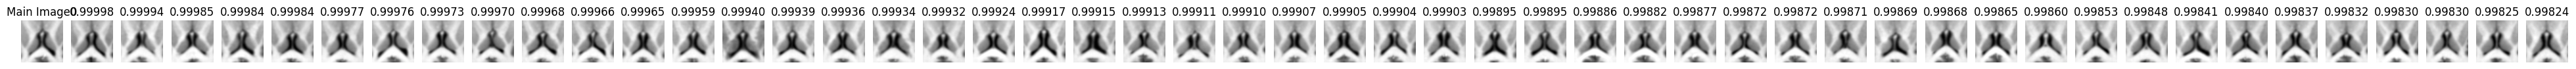

In [28]:
import matplotlib.pyplot as plt

class CustomCenterCrop:
    def __init__(self, output_size, x_center, y_center):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            self.output_size = output_size
        self.x_center = x_center
        self.y_center = y_center

    def __call__(self, img):
        w, h = self.output_size
        left = self.x_center - w//2
        top = self.y_center - h//2
        right = self.x_center + w//2
        bottom = self.y_center + h//2
        return img.crop((left, top, right, bottom))

def image_center_crop(image, x_center=100, y_center=150, output_size=100):
    transform = transforms.Compose([
        CustomCenterCrop(output_size, x_center, y_center),
        transforms.Resize((160, 160)),
        transforms.ToTensor(),
    ])
    return transform(image)

image_store = []
index_image = 0
counter = 0
score = []
for filename in os.listdir(folder_path):
    image = Image.open(f'/content/drive/MyDrive/picture_recognize/OASIS/OASIS/{filename}')
    image_store.append(image_center_crop(image,88,131,55))
with torch.no_grad():
    for i in range(len(image_store)):
        if i != index_image:
            input1 = image_store[index_image].unsqueeze(0).to(device)  # 将输入数据移到指定设备
            input2 = image_store[i].unsqueeze(0).to(device)  # 将输入数据移到指定设备
            score.append(model1((input1, input2)))
        else:
            score.append(0)
        torch.cuda.empty_cache()

sorted_list = sorted(enumerate(score), key=lambda x: x[1], reverse=True)
sorted_indices = [index for index, value in sorted_list]

fig, axes = plt.subplots(1, 51, figsize=(50, 50))
axes[0].imshow(image_store[index_image].squeeze(0), cmap='gray')
axes[0].axis('off')
axes[0].set_title('Main Image'+str(index_image))
print(score)
for j in range(50):
    axes[j + 1].imshow(image_store[sorted_indices[j]].squeeze(0), cmap='gray')
    axes[j + 1].axis('off')
    axes[j + 1].set_title(str(float(score[sorted_indices[j]]))[0:7])
plt.show()

In [ ]:
"""
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Assuming you have a dataset called 'train_dataset' containing your training samples

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the Siamese network
siamese_net = Siamese(input_shape=(your_input_shape), pretrained=True)
siamese_net = siamese_net.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(siamese_net.parameters(), lr=0.001)

# Set number of training epochs
num_epochs = 10

# Create a data loader for the training dataset
batch_size = 16  # adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (images1, images2, labels) in enumerate(train_loader):
        images1 = images1.to(device)
        images2 = images2.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = siamese_net((images1, images2))
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print training progress
        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/10:.4f}")
            running_loss = 0.0

print("Training finished.")
"""

NameError: ignored

In [ ]:
"""
import math
import os
import random
from functools import partial
from random import shuffle
import numpy as np
from PIL import Image

def load_dataset(dataset_path = '/content/drive/MyDrive/picture_recognize/OASIS/OASIS', train_ratio=0.1):
    types       = 0
    train_path  = os.path.join(dataset_path, 'images_background')
    lines       = []
    labels      = []
    for CT_image_filename in os.listdir(train_path):
        lines.append(os.path.join(train_path, CT_image_filename))
        labels.append(types)
        types += 1
    random.seed(1)
    shuffle_index = np.arange(len(lines), dtype=np.int32)
    shuffle(shuffle_index)
    random.seed(None)
    lines    = np.array(lines,dtype=np.object)
    labels   = np.array(labels)
    lines    = lines[shuffle_index]
    labels   = labels[shuffle_index]

    #-------------------------------------------------------------#
    #   将训练集和验证集进行划分
    #-------------------------------------------------------------#
    num_train           = int(len(lines)*train_ratio)

    val_lines      = lines[num_train:]
    val_labels     = labels[num_train:]

    train_lines    = lines[:num_train]
    train_labels   = labels[:num_train]
    return train_lines, train_labels, val_lines, val_labels

#---------------------------------------------------#
#   对输入图像进行resize
#---------------------------------------------------#
def letterbox_image(image, size, letterbox_image):
    w, h = size
    iw, ih = image.size
    if letterbox_image:
        '''resize image with unchanged aspect ratio using padding'''
        scale = min(w/iw, h/ih)
        nw = int(iw*scale)
        nh = int(ih*scale)

        image = image.resize((nw,nh), Image.BICUBIC)
        new_image = Image.new('RGB', size, (128,128,128))
        new_image.paste(image, ((w-nw)//2, (h-nh)//2))
    else:
        if h == w:
            new_image = resize(image, h)
        else:
            new_image = resize(image, [h ,w])
        new_image = center_crop(new_image, [h ,w])
    return new_image

#---------------------------------------------------------#
#   将图像转换成RGB图像，防止灰度图在预测时报错。
#   代码仅仅支持RGB图像的预测，所有其它类型的图像都会转化成RGB
#---------------------------------------------------------#
def cvtColor(image):
    if len(np.shape(image)) == 3 and np.shape(image)[2] == 3:
        return image
    else:
        image = image.convert('RGB')
        return image

#----------------------------------------#
#   预处理训练图片
#----------------------------------------#
def preprocess_input(x):
    x /= 255.0
    return x

def show_config(**kwargs):
    print('Configurations:')
    print('-' * 70)
    print('|%25s | %40s|' % ('keys', 'values'))
    print('-' * 70)
    for key, value in kwargs.items():
        print('|%25s | %40s|' % (str(key), str(value)))
    print('-' * 70)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def get_lr_scheduler(lr_decay_type, lr, min_lr, total_iters, warmup_iters_ratio = 0.05, warmup_lr_ratio = 0.1, no_aug_iter_ratio = 0.05, step_num = 10):
    def yolox_warm_cos_lr(lr, min_lr, total_iters, warmup_total_iters, warmup_lr_start, no_aug_iter, iters):
        if iters <= warmup_total_iters:
            # lr = (lr - warmup_lr_start) * iters / float(warmup_total_iters) + warmup_lr_start
            lr = (lr - warmup_lr_start) * pow(iters / float(warmup_total_iters), 2
            ) + warmup_lr_start
        elif iters >= total_iters - no_aug_iter:
            lr = min_lr
        else:
            lr = min_lr + 0.5 * (lr - min_lr) * (
                1.0
                + math.cos(
                    math.pi
                    * (iters - warmup_total_iters)
                    / (total_iters - warmup_total_iters - no_aug_iter)
                )
            )
        return lr

    def step_lr(lr, decay_rate, step_size, iters):
        if step_size < 1:
            raise ValueError("step_size must above 1.")
        n       = iters // step_size
        out_lr  = lr * decay_rate ** n
        return out_lr

    if lr_decay_type == "cos":
        warmup_total_iters  = min(max(warmup_iters_ratio * total_iters, 1), 3)
        warmup_lr_start     = max(warmup_lr_ratio * lr, 1e-6)
        no_aug_iter         = min(max(no_aug_iter_ratio * total_iters, 1), 15)
        func = partial(yolox_warm_cos_lr ,lr, min_lr, total_iters, warmup_total_iters, warmup_lr_start, no_aug_iter)
    else:
        decay_rate  = (min_lr / lr) ** (1 / (step_num - 1))
        step_size   = total_iters / step_num
        func = partial(step_lr, lr, decay_rate, step_size)

    return func

def set_optimizer_lr(optimizer, lr_scheduler_func, epoch):
    lr = lr_scheduler_func(epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def download_weights(backbone, model_dir="./model_data"):
    import os
    from torch.hub import load_state_dict_from_url

    download_urls = {
        'vgg16'         : 'https://download.pytorch.org/models/vgg16-397923af.pth',
    }
    url = download_urls[backbone]

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    load_state_dict_from_url(url, model_dir)
"""

In [ ]:
"""
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends.cudnn as cudnn
from PIL import Image


#---------------------------------------------------#
#   使用自己训练好的模型预测需要修改model_path参数
#---------------------------------------------------#
class Siamese(object):
    _defaults = {
        #-----------------------------------------------------#
        #   使用自己训练好的模型进行预测一定要修改model_path
        #   model_path指向logs文件夹下的权值文件
        #-----------------------------------------------------#
        "model_path"        : 'model_data/Omniglot_vgg.pth',
        #-----------------------------------------------------#
        #   输入图片的大小。
        #-----------------------------------------------------#
        "input_shape"       : [105, 105],
        #--------------------------------------------------------------------#
        #   该变量用于控制是否使用letterbox_image对输入图像进行不失真的resize
        #   否则对图像进行CenterCrop
        #--------------------------------------------------------------------#
        "letterbox_image"   : False,
        #-------------------------------#
        #   是否使用Cuda
        #   没有GPU可以设置成False
        #-------------------------------#
        "cuda"              : True
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    #---------------------------------------------------#
    #   初始化Siamese
    #---------------------------------------------------#
    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults)
        for name, value in kwargs.items():
            setattr(self, name, value)
        self.generate()

        show_config(**self._defaults)

    #---------------------------------------------------#
    #   载入模型
    #---------------------------------------------------#
    def generate(self):
        #---------------------------#
        #   载入模型与权值
        #---------------------------#
        print('Loading weights into state dict...')
        device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model   = siamese(self.input_shape)
        model.load_state_dict(torch.load(self.model_path, map_location=device))
        self.net = model.eval()
        print('{} model loaded.'.format(self.model_path))

        if self.cuda:
            self.net = torch.nn.DataParallel(self.net)
            cudnn.benchmark = True
            self.net = self.net.cuda()

    def letterbox_image(self, image, size):
        image   = image.convert("RGB")
        iw, ih  = image.size
        w, h    = size
        scale   = min(w/iw, h/ih)
        nw      = int(iw*scale)
        nh      = int(ih*scale)

        image       = image.resize((nw,nh), Image.BICUBIC)
        new_image   = Image.new('RGB', size, (128,128,128))
        new_image.paste(image, ((w-nw)//2, (h-nh)//2))
        if self.input_shape[-1]==1:
            new_image = new_image.convert("L")
        return new_image

    #---------------------------------------------------#
    #   检测图片
    #---------------------------------------------------#
    def detect_image(self, image_1, image_2):
        #---------------------------------------------------------#
        #   在这里将图像转换成RGB图像，防止灰度图在预测时报错。
        #---------------------------------------------------------#
        image_1 = cvtColor(image_1)
        image_2 = cvtColor(image_2)

        #---------------------------------------------------#
        #   对输入图像进行不失真的resize
        #---------------------------------------------------#
        image_1 = letterbox_image(image_1, [self.input_shape[1], self.input_shape[0]], self.letterbox_image)
        image_2 = letterbox_image(image_2, [self.input_shape[1], self.input_shape[0]], self.letterbox_image)

        #---------------------------------------------------------#
        #   归一化+添加上batch_size维度
        #---------------------------------------------------------#
        photo_1  = preprocess_input(np.array(image_1, np.float32))
        photo_2  = preprocess_input(np.array(image_2, np.float32))

        with torch.no_grad():
            #---------------------------------------------------#
            #   添加上batch维度，才可以放入网络中预测
            #---------------------------------------------------#
            photo_1 = torch.from_numpy(np.expand_dims(np.transpose(photo_1, (2, 0, 1)), 0)).type(torch.FloatTensor)
            photo_2 = torch.from_numpy(np.expand_dims(np.transpose(photo_2, (2, 0, 1)), 0)).type(torch.FloatTensor)

            if self.cuda:
                photo_1 = photo_1.cuda()
                photo_2 = photo_2.cuda()

            #---------------------------------------------------#
            #   获得预测结果，output输出为概率
            #---------------------------------------------------#
            output = self.net([photo_1, photo_2])[0]
            output = torch.nn.Sigmoid()(output)

        plt.subplot(1, 2, 1)
        plt.imshow(np.array(image_1))

        plt.subplot(1, 2, 2)
        plt.imshow(np.array(image_2))
        plt.text(-12, -12, 'Similarity:%.3f' % output, ha='center', va= 'bottom',fontsize=11)
        plt.show()
        return output
"""

In [ ]:
if __name__ == "__main__":
    model = Siamese()

    while True:
        image_1 = input('Input image_1 filename:')
        try:
            image_1 = Image.open(image_1)
        except:
            print('Image_1 Open Error! Try again!')
            continue

        image_2 = input('Input image_2 filename:')
        try:
            image_2 = Image.open(image_2)
        except:
            print('Image_2 Open Error! Try again!')
            continue
        probability = model.detect_image(image_1,image_2)
        print(probability)

NameError: ignored